In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# data prep
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder, StandardScaler
from category_encoders import BinaryEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# evaluation
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score, precision_score

In [ ]:
!pip install category_encoders

## Business Problem Understanding

**Context**

Daegu, salah satu kota besar di Korea Selatan, memiliki pasar properti yang berkembang dengan pesat. Banyak apartemen di kota ini memiliki variasi harga yang signifikan, yang dipengaruhi oleh berbagai faktor seperti lokasi, fasilitas, ukuran, dan aksesibilitas. Pasar properti di Daegu penting baik bagi pengembang properti maupun masyarakat yang ingin membeli atau menjual apartemen.

Platform atau agen properti yang dapat memprediksi harga jual apartemen secara akurat akan memiliki keunggulan kompetitif dalam membantu klien menentukan nilai pasar yang optimal.

**Problem Statement**

Salah satu tantangan terbesar dalam industri properti adalah menentukan harga jual yang sesuai untuk setiap unit apartemen. Faktor-faktor seperti jarak ke transportasi umum, jumlah fasilitas publik terdekat, ukuran apartemen, serta usia bangunan dapat memengaruhi nilai properti. Tanpa panduan harga yang tepat, penjual berisiko menawarkan harga yang tidak kompetitif, baik terlalu tinggi atau terlalu rendah, yang dapat berdampak negatif terhadap penjualan.

**Goals**

Tujuan dari analisis ini adalah untuk membangun sebuah model prediksi yang dapat membantu menentukan harga jual apartemen di daerah Daegu. Model ini akan mempertimbangkan berbagai fitur properti seperti ukuran, lokasi, fasilitas, dan aksesibilitas untuk memberikan estimasi harga yang akurat. Hal ini akan bermanfaat bagi penjual, pembeli, dan agen properti dalam menentukan harga yang sesuai dengan pasar.

**Analytic Approach**

Langkah-langkah yang diambil untuk mencapai tujuan ini adalah:

Menganalisis data untuk memahami pola dan hubungan antar variabel.
Menggunakan algoritma regresi untuk membangun model prediksi harga jual berdasarkan fitur-fitur yang tersedia.
Mengevaluasi model menggunakan metrik seperti RMSE, MAE, dan MAPE untuk memastikan tingkat akurasi prediksi.

**Metric Evaluation**

Evaluasi model akan menggunakan beberapa metrik sebagai berikut:

- **RMSE (Root Mean Squared Error):** Untuk mengukur deviasi kuadrat rata-rata antara harga prediksi dan harga aktual.
- **MAE (Mean Absolute Error):** Untuk mengukur rata-rata kesalahan absolut antara harga prediksi dan harga aktual.
- **MAPE (Mean Absolute Percentage Error):** Untuk mengukur kesalahan prediksi dalam bentuk persentase.

Jika model yang digunakan adalah model regresi linear, R-squared juga akan digunakan untuk mengukur seberapa baik model memprediksi varians dari harga properti.

##Data Understanding

In [ ]:
df = pd.read_csv('data_daegu_apartment.csv')
if 'Unnamed: 0' in df.columns:
    df.drop(columns='Unnamed: 0', inplace=True)
df

### Penjelasan setiap variable (Data Dictionary)

|kolom | Penjelasan |
|---- | ---- |
| HallwayType| Jenis lorong apartemen, yang dapat mempengaruhi layout dan kenyamanan. Contoh: terraced atau mixed.|
|TimeToSubway|Estimasi waktu tempuh ke stasiun subway terdekat dari apartemen, dinyatakan dalam rentang waktu (misalnya, "0-5min", "10min~15min").|
|SubwayStation|	Nama stasiun subway terdekat dari apartemen. Ini bisa menjadi salah satu faktor utama yang mempengaruhi harga properti.|
|N_FacilitiesNearBy(ETC)|	Jumlah fasilitas umum lainnya (selain kantor publik dan sekolah) di sekitar apartemen, seperti supermarket, pusat perbelanjaan, dll.|
|N_FacilitiesNearBy(PublicOffice)|	Jumlah fasilitas kantor publik yang berada di dekat apartemen, seperti kantor pemerintahan, balai kota, dll.|
|N_SchoolNearBy(University)|	Jumlah sekolah atau universitas di dekat apartemen. Kedekatan dengan lembaga pendidikan bisa meningkatkan nilai properti.|
|N_Parkinglot(Basement)|	Jumlah tempat parkir yang tersedia di basement apartemen. Ketersediaan parkir sering menjadi salah satu faktor penting dalam menentukan harga.|
|YearBuilt|	Tahun bangunan apartemen tersebut dibangun. Apartemen yang lebih baru cenderung memiliki harga lebih tinggi karena kondisi bangunan yang lebih baik.|
|N_FacilitiesInApt|	Jumlah fasilitas yang ada di dalam kompleks apartemen, seperti kolam renang, gym, taman, dll. Semakin banyak fasilitas, biasanya semakin mahal harganya.|
|Size(sqf)|	Ukuran apartemen dalam satuan square feet (sqf). Apartemen yang lebih besar umumnya memiliki harga yang lebih tinggi.|
|SalePrice|	Harga jual apartemen dalam mata uang lokal (won Korea). Ini adalah target variabel yang akan diprediksi berdasarkan fitur-fitur lain di dataset.|

### Missing Values

In [ ]:
# Jumlah data kosong (NaN) untuk setiap variable
df.isnull().sum()

,0
HallwayType,0
TimeToSubway,0
SubwayStation,0
N_FacilitiesNearBy(ETC),0
N_FacilitiesNearBy(PublicOffice),0
N_SchoolNearBy(University),0
N_Parkinglot(Basement),0
YearBuilt,0
N_FacilitiesInApt,0
Size(sqf),0


In [ ]:
# Agar lebih "cantik" dibuat dataframe
missing = pd.DataFrame({'jumlah':df.isnull().sum().sort_values(ascending = False)})
missing

,jumlah
HallwayType,0
TimeToSubway,0
SubwayStation,0
N_FacilitiesNearBy(ETC),0
N_FacilitiesNearBy(PublicOffice),0
N_SchoolNearBy(University),0
N_Parkinglot(Basement),0
YearBuilt,0
N_FacilitiesInApt,0
Size(sqf),0


In [ ]:
total_baris_data = len(df)
missing['persentase %'] = round((missing['jumlah']/total_baris_data)*100,2)
missing

,jumlah,persentase %
HallwayType,0,0.0
TimeToSubway,0,0.0
SubwayStation,0,0.0
N_FacilitiesNearBy(ETC),0,0.0
N_FacilitiesNearBy(PublicOffice),0,0.0
N_SchoolNearBy(University),0,0.0
N_Parkinglot(Basement),0,0.0
YearBuilt,0,0.0
N_FacilitiesInApt,0,0.0
Size(sqf),0,0.0


<Axes: >

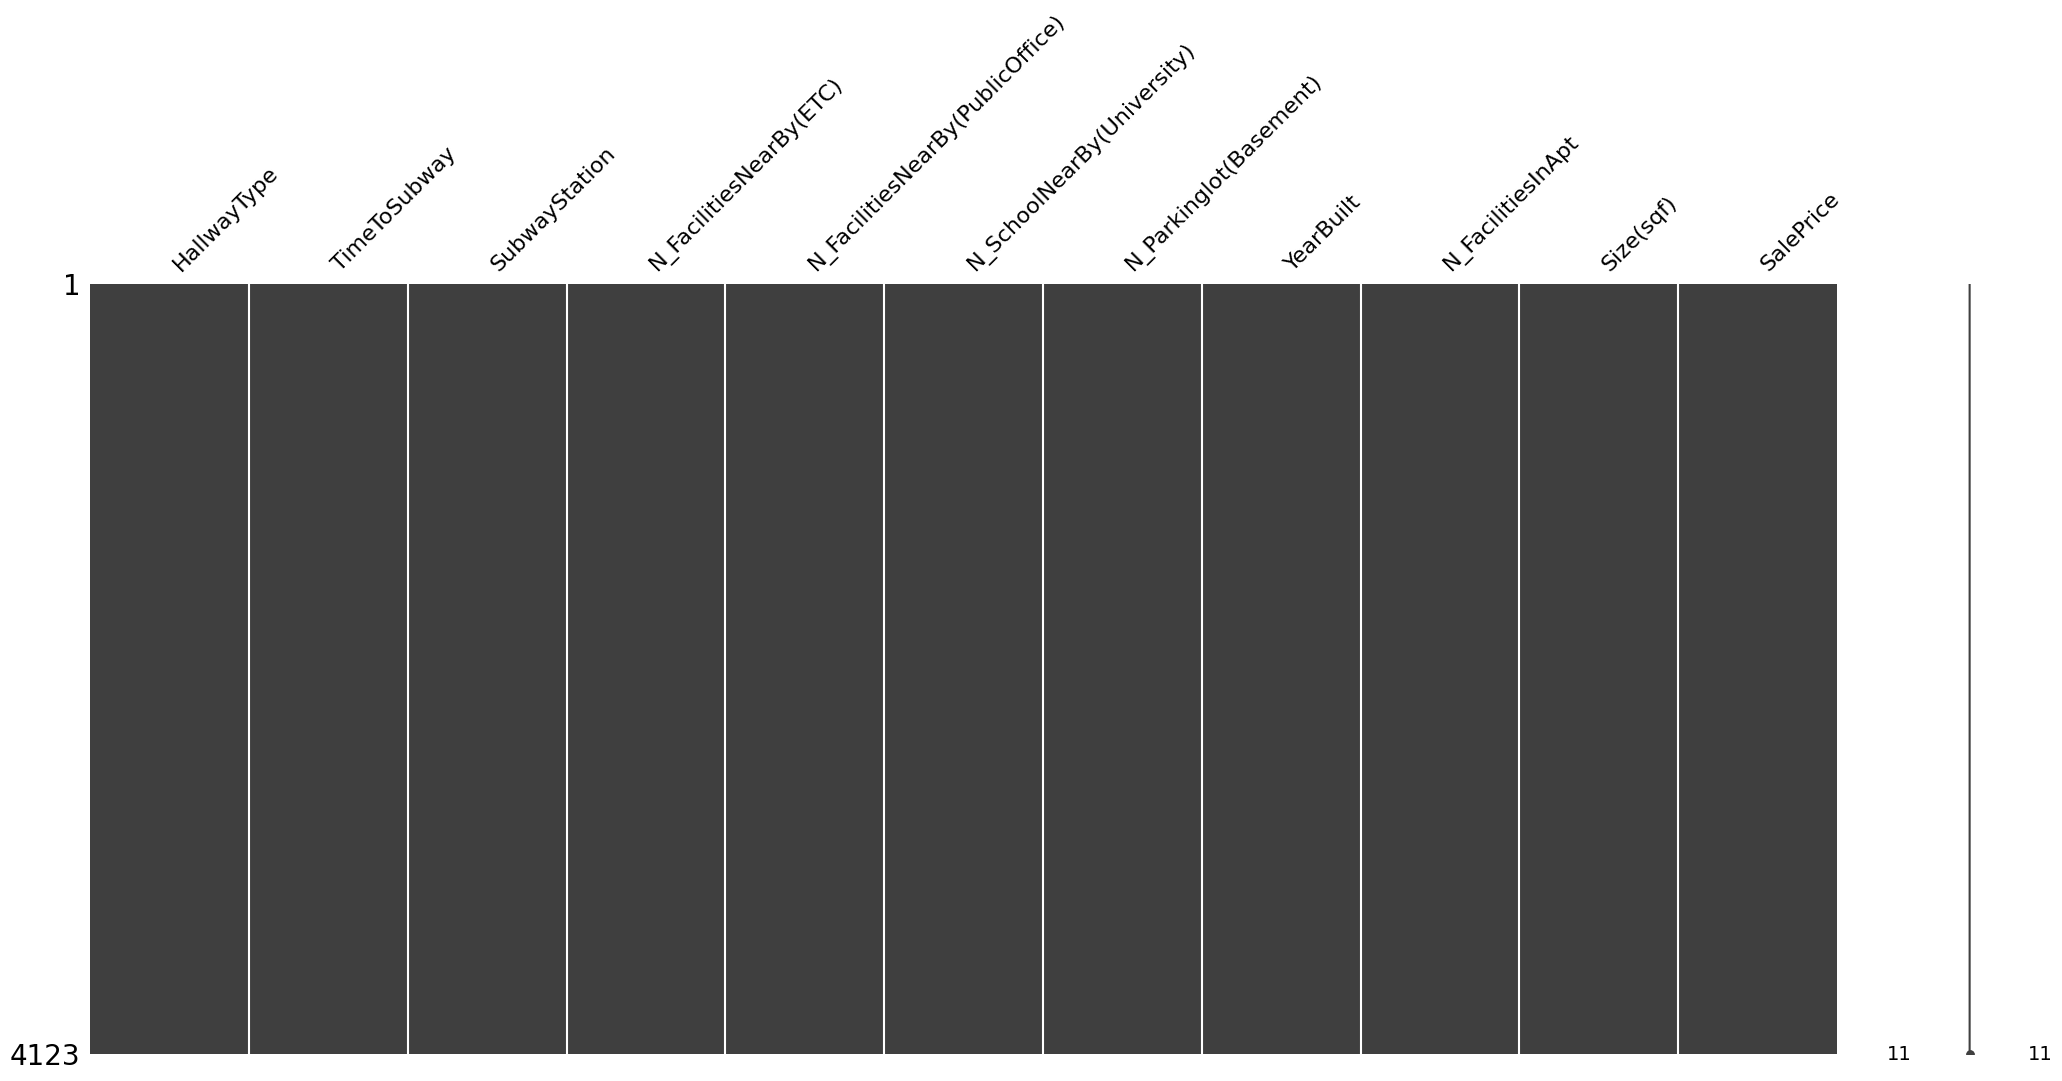

In [ ]:
import missingno

# Hubungan antar missing values secara visualisasi
missingno.matrix(df)

### Data Duplikat

In [ ]:
# jumlah yang duplikat
df.duplicated().sum()

1422

In [ ]:
# mendrop data dupliat
df.drop_duplicates(inplace = True)

### Variable Numerik

#### Statistika Deskriptif

In [ ]:
# Statistika dekriptif
df.describe() # OTOMATIS hanya mengambil yang numerik

,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
count,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000
mean,1.890411,4.027027,2.680489,533.746390,2002.358386,5.713439,984.028878,229511.365790
std,2.153168,1.887486,1.504470,418.224859,9.151949,2.386552,391.982619,105079.891321
min,0.000000,0.000000,0.000000,0.000000,1978.000000,1.000000,135.000000,32743.000000
25%,0.000000,3.000000,2.000000,181.000000,1993.000000,4.000000,743.000000,153539.000000
50%,1.000000,4.000000,2.000000,536.000000,2006.000000,5.000000,910.000000,221238.000000
75%,5.000000,5.000000,4.000000,798.000000,2007.000000,7.000000,1167.000000,300884.000000
max,5.000000,7.000000,5.000000,1321.000000,2015.000000,10.000000,2337.000000,585840.000000


#### Distribusi Data

In [ ]:
len(df.select_dtypes(include = 'number').columns)

8

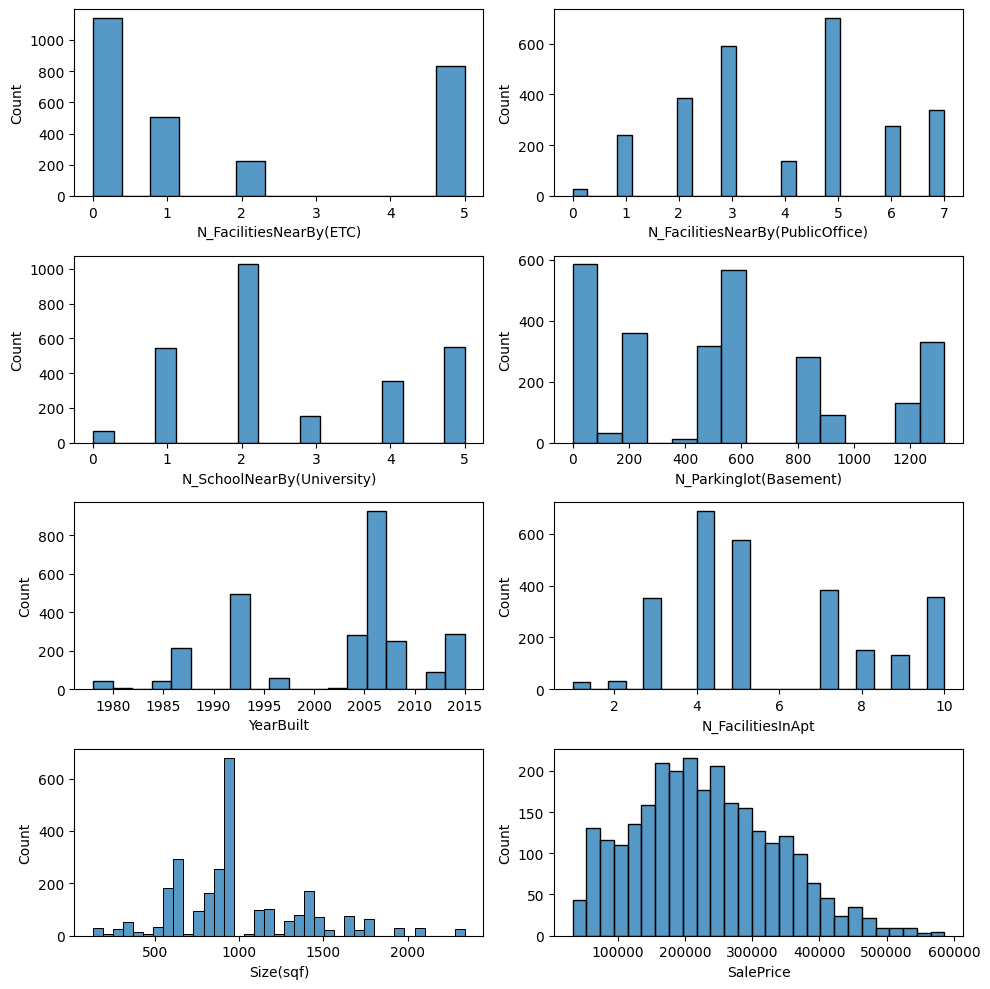

In [ ]:
numerik = df.select_dtypes(include = 'number')

# ganti ukuran pigura (wadah grafik nya)
plt.figure(figsize = (10,10))

posisi = 1 # menginisiasi posisi mulai dari 1
for setiap_kolom in numerik.columns: # numerik.columns = nama-nama kolom dalam list
    plt.subplot(4,2,posisi)
    sns.histplot(df[setiap_kolom])
    posisi = posisi + 1
    # agar tidak bertumpuk
    plt.tight_layout()

#### Outliers

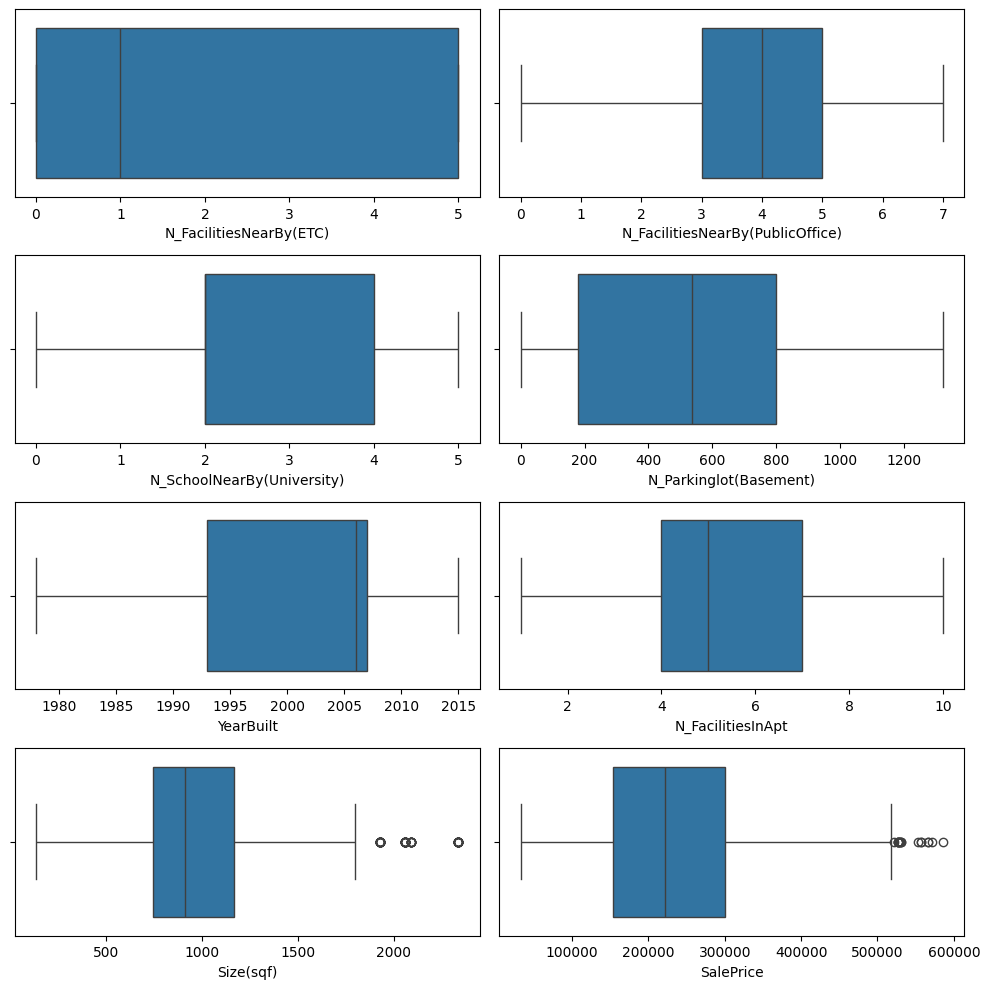

In [ ]:
numerik = df.select_dtypes(include = 'number')

# ganti ukuran pigura (wadah grafik nya)
plt.figure(figsize = (10,10))

posisi = 1 # menginisiasi posisi mulai dari 1
for setiap_kolom in numerik.columns: # numerik.columns = nama-nama kolom dalam list
    plt.subplot(4,2,posisi)
    sns.boxplot(x = df[setiap_kolom])
    posisi = posisi + 1
    # agar tidak bertumpuk
    plt.tight_layout()

#### Korelasi

<Axes: >

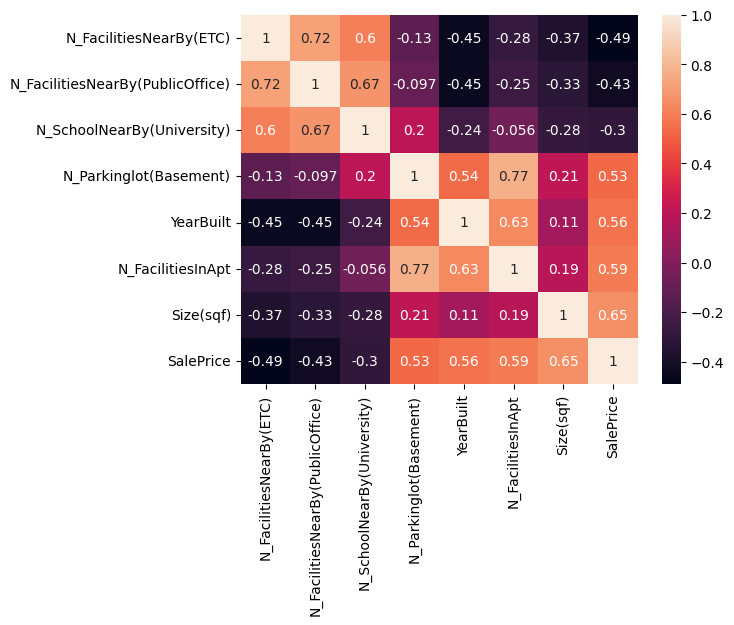

In [ ]:
sns.heatmap(numerik.corr(method = 'spearman'), annot = True)

#### Multikolineartias dengan VIF

In [ ]:
import pandas as pd
file_path = '/content/data_daegu_apartment.csv'
data = pd.read_csv(file_path)

# Memilih hanya kolom numerik
numerik = data.select_dtypes(include=[float, int])

# Membuat fungsi untuk menghitung VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(x):
    # dataframe kosong
    vif = pd.DataFrame()
    vif["variables"] = x.columns
    # menghitung VIF untuk setiap kolom
    vif["VIF"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    return vif

# Menghitung VIF dengan menghapus kolom 'SalePrice' karena itu adalah target
vif_result = calc_vif(numerik.drop(columns='SalePrice')).sort_values(by='VIF', ascending=False)

# Menampilkan hasil VIF
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    print(vif_result)

                          variables        VIF
4                         YearBuilt  34.327180
5                 N_FacilitiesInApt  27.840728
2        N_SchoolNearBy(University)  18.284972
1  N_FacilitiesNearBy(PublicOffice)  15.342707
3            N_Parkinglot(Basement)  12.254853
6                         Size(sqf)   8.567090
0           N_FacilitiesNearBy(ETC)   5.474361


In [ ]:
# Menghapus variabel dengan VIF tinggi
numerik_reduced = numerik.drop(columns=['YearBuilt'])

# Menghitung ulang VIF
vif_result_reduced = calc_vif(numerik_reduced.drop(columns='SalePrice')).sort_values(by='VIF', ascending=False)

# Menampilkan hasil VIF yang baru
vif_result_reduced


,variables,VIF
2,N_SchoolNearBy(University),16.836527
4,N_FacilitiesInApt,16.028845
1,N_FacilitiesNearBy(PublicOffice),12.969386
3,N_Parkinglot(Basement),9.435882
0,N_FacilitiesNearBy(ETC),5.258321
5,Size(sqf),5.211340


### Variabel Kategorik

#### Describe

In [ ]:
df.describe(include = 'object')

,HallwayType,TimeToSubway,SubwayStation
count,2701,2701,2701
unique,3,5,8
top,terraced,0-5min,Myung-duk
freq,1667,1248,709


#### Unique Values

In [ ]:
kategorik = df.select_dtypes(include = 'object')
kategorik.nunique()

,0
HallwayType,3
TimeToSubway,5
SubwayStation,8


#### Value Counts

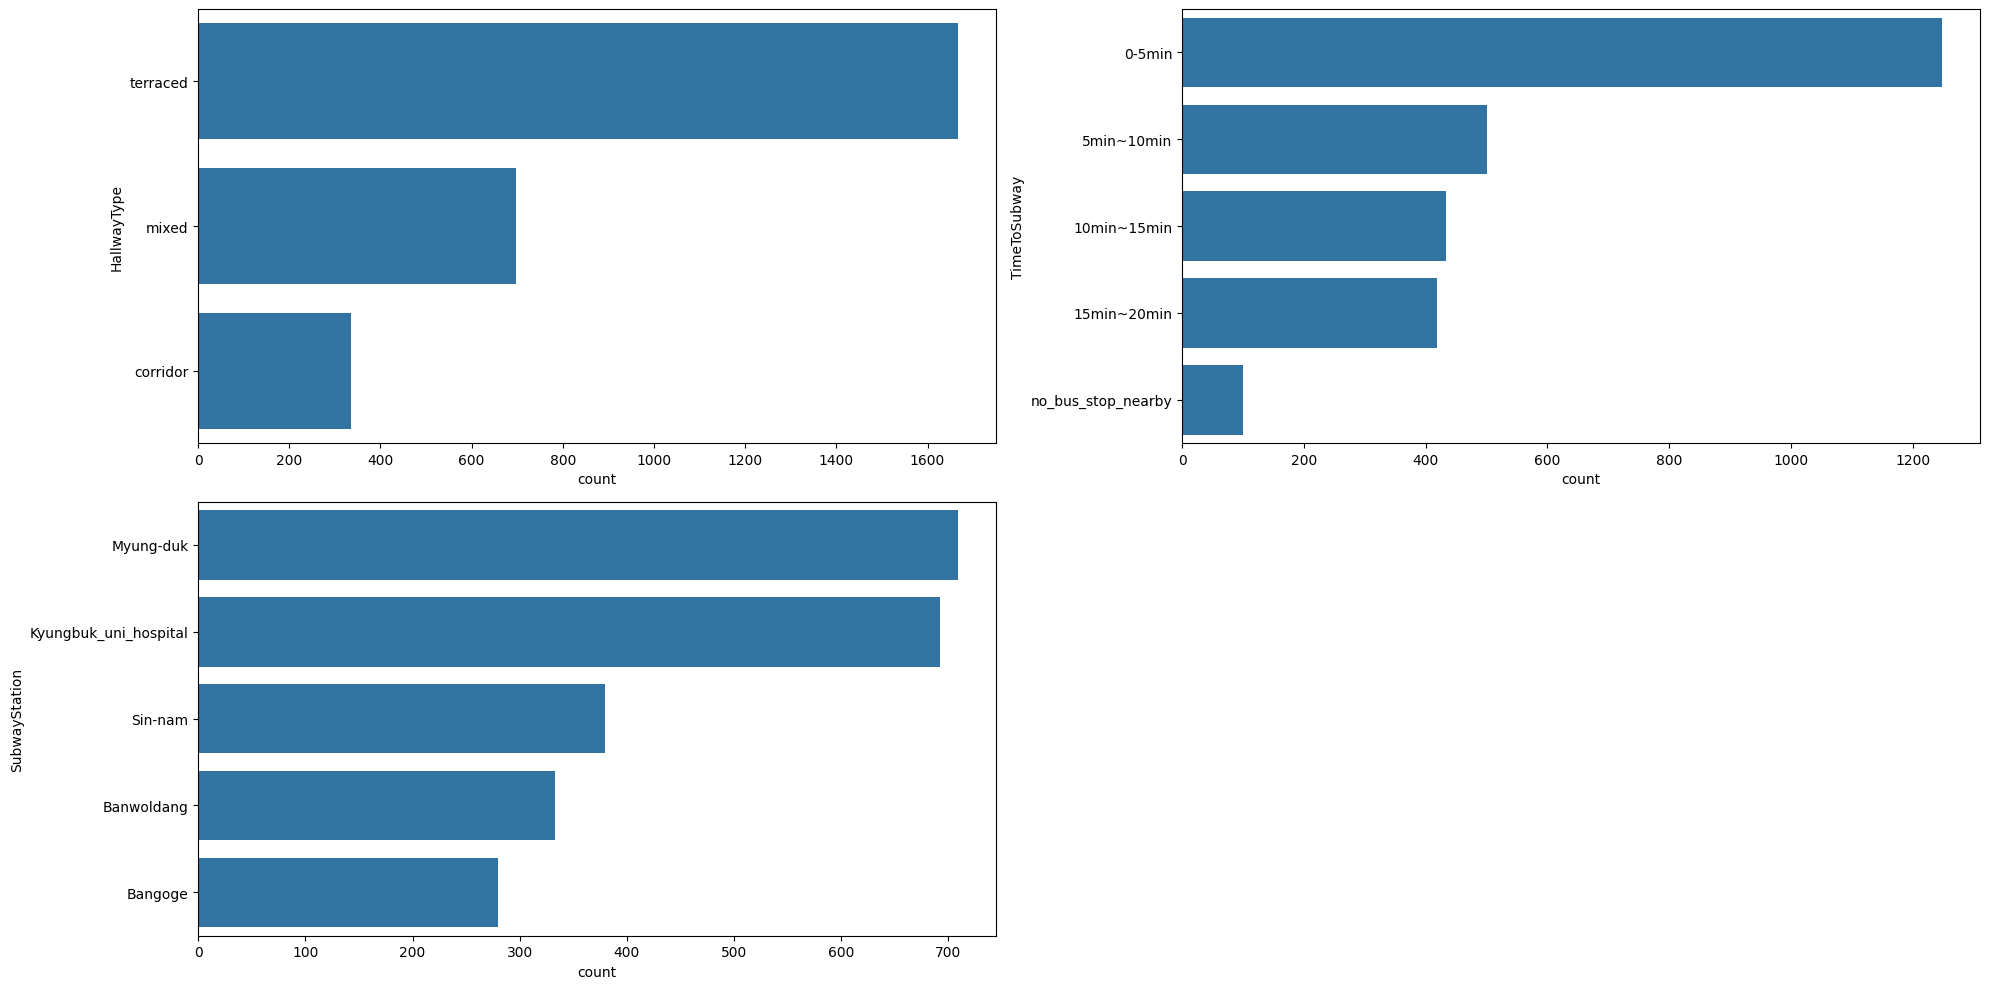

In [ ]:
plt.figure(figsize = (20,10)) # (horizontal, vertikal)

posisi = 1 # menginisiasi posisi mulai dari 1
for setiap_kolom in kategorik.columns: # kategorik.columns = nama-nama kolom dalam list
    plt.subplot(2,2,posisi)
    sns.barplot(df[setiap_kolom].value_counts().head(5), orient = 'h')
    posisi = posisi + 1
    # agar tidak bertumpuk
    plt.tight_layout()

#Data Cleaning

In [ ]:
# Code untuk membersihkan dataset yang diunggah
import pandas as pd

# Memuat dataset
file_path = '/content/data_daegu_apartment.csv'
data = pd.read_csv(file_path)

# 1. Mengecek data yang hilang (missing values)
missing_data = data.isnull().sum()

# 2. Mengatasi missing values (jika ada)
# Strategi yang digunakan:
# - Mengisi missing values dengan median untuk kolom numerik
# - Mengisi missing values dengan modus untuk kolom kategorikal
for column in data.columns:
    if data[column].dtype in ['float64', 'int64']:  # Untuk kolom numerik
        data[column].fillna(data[column].median(), inplace=True)
    else:  # Untuk kolom kategorikal
        data[column].fillna(data[column].mode()[0], inplace=True)

# 3. Mengecek nilai duplikat
duplicates = data.duplicated().sum()

# Menghapus data duplikat (jika ada)
data_cleaned = data.drop_duplicates()

# 4. Mengatasi data yang tidak konsisten atau outliers
# Misalnya, ukuran apartemen (Size(sqf)) yang kurang realistis atau harga yang terlalu rendah/tinggi
# Menentukan batas bawah dan atas untuk ukuran apartemen dan harga
# Ini adalah contoh sederhana untuk mendeteksi outlier dengan IQR

Q1 = data_cleaned['Size(sqf)'].quantile(0.25)
Q3 = data_cleaned['Size(sqf)'].quantile(0.75)
IQR = Q3 - Q1

# Menghapus data yang terlalu ekstrem (outliers)
data_cleaned = data_cleaned[~((data_cleaned['Size(sqf)'] < (Q1 - 1.5 * IQR)) |
                              (data_cleaned['Size(sqf)'] > (Q3 + 1.5 * IQR)))]

# Lakukan hal serupa untuk SalePrice
Q1_price = data_cleaned['SalePrice'].quantile(0.25)
Q3_price = data_cleaned['SalePrice'].quantile(0.75)
IQR_price = Q3_price - Q1_price

data_cleaned = data_cleaned[~((data_cleaned['SalePrice'] < (Q1_price - 1.5 * IQR_price)) |
                              (data_cleaned['SalePrice'] > (Q3_price + 1.5 * IQR_price)))]

# 5. Normalisasi atau standarisasi (optional, tergantung pada model yang digunakan)
# Standarisasi data numerik agar memiliki distribusi serupa (skala yang sama)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Kolom yang akan dinormalisasi: semua kolom numerik kecuali target 'SalePrice'
num_columns = data_cleaned.select_dtypes(include=['float64', 'int64']).columns.drop('SalePrice')

# Standarisasi kolom numerik
data_cleaned[num_columns] = scaler.fit_transform(data_cleaned[num_columns])

# Dataset yang sudah dibersihkan
data_cleaned.head()

,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
0,terraced,0-5min,Kyungbuk_uni_hospital,-0.887241,-0.555303,-0.450578,1.797199,0.501050,1.829245,1.296919,346017
1,terraced,10min~15min,Kyungbuk_uni_hospital,-0.422122,0.506042,-1.113852,-1.263879,-1.781631,-0.709624,-0.094098,150442
2,mixed,15min~20min,Chil-sung-market,-0.422122,1.567386,0.212695,-1.128902,-0.585941,-0.286479,-1.141037,61946
3,mixed,5min~10min,Bangoge,1.438354,0.506042,0.875969,0.659538,0.283652,0.559811,-0.094098,165486
4,terraced,0-5min,Sin-nam,-0.887241,-1.616647,-0.450578,0.028041,0.392351,-0.286479,2.343858,311504


# Data Splitting

In [ ]:
from sklearn.model_selection import train_test_split

# Memisahkan fitur independen (X) dan target (y)
X = data_cleaned.drop(columns=['SalePrice'])
y = data_cleaned['SalePrice']

# Membagi data menjadi training set dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Menampilkan ukuran dari training dan testing set
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((2085, 10), (522, 10), (2085,), (522,))

# Data Preparation

Penggunaan One-Hot Encoding: Untuk variabel kategorikal, menggunakan teknik one-hot encoding akan membantu agar algoritma dapat memahami variabel non-numerik.

One-Hot Encoding akan diterapkan pada kolom HallwayType, TimeToSubway, dan SubwayStation.

In [ ]:
# One-Hot Encoding untuk variabel kategorikal
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

# Menyelaraskan kolom antara X_train_encoded dan X_test_encoded agar sesuai setelah encoding
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

# Menampilkan beberapa baris dari X_train_encoded untuk memastikan data siap
print(X_train_encoded.head())


      N_FacilitiesNearBy(ETC)  N_FacilitiesNearBy(PublicOffice)  \
48                  -0.887241                         -0.555303   
1997                 1.438354                          1.036714   
2901                -0.887241                         -1.616647   
851                 -0.887241                         -0.555303   
2248                -0.422122                          0.506042   

      N_SchoolNearBy(University)  N_Parkinglot(Basement)  YearBuilt  \
48                     -0.450578                1.797199   0.501050   
1997                    1.539243                0.028041  -1.020737   
2901                   -1.113852                1.920124   1.370643   
851                    -0.450578                1.797199   0.501050   
2248                   -1.113852               -1.263879  -1.781631   

      N_FacilitiesInApt  Size(sqf)  HallwayType_mixed  HallwayType_terraced  \
48             1.829245   1.296919              False                  True   
1997        

In [ ]:
transformer = ColumnTransformer([
    ('one hot', OneHotEncoder(drop = 'first'), ['race','gender']),
    ('binary', BinaryEncoder(), ['occupation','native-country']),
    ('scaler', MinMaxScaler(), X_train.select_dtypes(include = 'number').columns)
], remainder = 'passthrough')
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('one hot', OneHotEncoder(drop='first'),
                                 ['race', 'gender']),
                                ('binary', BinaryEncoder(),
                                 ['occupation', 'native-country']),
                                ('scaler', MinMaxScaler(),
                                 Index(['N_FacilitiesNearBy(ETC)', 'N_FacilitiesNearBy(PublicOffice)',
       'N_SchoolNearBy(University)', 'N_Parkinglot(Basement)', 'YearBuilt',
       'N_FacilitiesInApt', 'Size(sqf)'],
      dtype='object'))])

# Modelling

### Rule Based Model (Non ML)

In [6]:
df0['eksperimen'] = 'Rule Based'
df1['eksperimen'] = 'Based Model'
df2['eksperimen'] = 'Without Outliers'
df3['eksperimen'] = 'Resampling'
# df4['eksperimen'] = 'Resampling with Feature Selection'

# penggabungan semua df score
df_gab = pd.concat([df0, df1, df2, df3], axis = 0)
df_gab = df_gab.set_index(['eksperimen','model'])

# highlight ke score terbaik
df_gab.style.highlight_max(subset = ['train_score_mean','test_score'],color = 'lightgreen', axis = 0).highlight_min(subset = ['train_score_std'],color = 'lightgreen', axis = 0)



NameError: name 'df0' is not defined

In [3]:
def rule_based_pricing(row):
    # Aturan dasar untuk prediksi harga
    price = 0

    # Aturan berdasarkan ukuran apartemen
    if row['Size(sqf)'] > 1000:
        price += 100000  # Tambahkan nilai jika apartemen besar
    else:
        price += 50000  # Harga lebih rendah jika apartemen kecil

    # Aturan berdasarkan tahun dibangun
    if row['YearBuilt'] > 2000:
        price += 50000  # Tambahkan nilai jika apartemen baru
    else:
        price += 20000  # Harga lebih rendah jika apartemen lama

    # Aturan berdasarkan jarak ke subway
    if row['TimeToSubway'] in ['0-5min', '5min~10min']:
        price += 30000  # Tambahkan nilai jika dekat dengan subway
    else:
        price -= 10000  # Kurangi nilai jika jauh dari subway

    # Aturan berdasarkan jumlah fasilitas
    facilities_score = row['N_FacilitiesNearBy(ETC)'] + row['N_FacilitiesNearBy(PublicOffice)'] + row['N_SchoolNearBy(University)']
    price += facilities_score * 5000  # Semakin banyak fasilitas, semakin tinggi harga

    return price

# Terapkan aturan ke setiap baris di data
data['PredictedPrice'] = data.apply(rule_based_pricing, axis=1)

# Lihat hasil prediksi
data[['Size(sqf)', 'YearBuilt', 'TimeToSubway', 'PredictedPrice']].head()


,Size(sqf),YearBuilt,TimeToSubway,PredictedPrice
0,1387,2007,0-5min,205000.0
1,914,1986,10min~15min,95000.0
2,558,1997,15min~20min,115000.0
3,914,2005,5min~10min,200000.0
4,1743,2006,0-5min,195000.0


In [5]:
# Import library yang diperlukan
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Load data
data = pd.read_csv('/content/data_daegu_apartment.csv')

# Pra-pemrosesan data
# Mengubah data kategorikal menjadi numerik dengan One-Hot Encoding
data_encoded = pd.get_dummies(data, columns=['HallwayType', 'TimeToSubway', 'SubwayStation'], drop_first=True)

# Pisahkan fitur (X) dan target (y)
X = data_encoded.drop('SalePrice', axis=1)
y = data_encoded['SalePrice']

# Bagi data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fungsi Rule-Based Pricing
def rule_based_pricing(row):
    price = 0

    # Aturan berdasarkan ukuran apartemen
    if row['Size(sqf)'] > 1000:
        price += 100000
    else:
        price += 50000

    # Aturan berdasarkan tahun dibangun
    if row['YearBuilt'] > 2000:
        price += 50000
    else:
        price += 20000

    # Aturan berdasarkan jarak ke subway (menyesuaikan dengan kolom encoded)
    if 'TimeToSubway_0-5min' in row.index and row['TimeToSubway_0-5min'] == 1:
        price += 30000
    elif 'TimeToSubway_5min~10min' in row.index and row['TimeToSubway_5min~10min'] == 1:
        price += 20000
    else:
        price -= 10000

    # Aturan berdasarkan jumlah fasilitas
    facilities_score = row['N_FacilitiesNearBy(ETC)'] + row['N_FacilitiesNearBy(PublicOffice)'] + row['N_SchoolNearBy(University)']
    price += facilities_score * 5000

    return price

# Prediksi harga pada data training dan testing
y_pred_train_rule_based = X_train.apply(rule_based_pricing, axis=1)
y_pred_test_rule_based = X_test.apply(rule_based_pricing, axis=1)

# Evaluasi menggunakan Mean Squared Error dan RMSE
mse_train_rule_based = mean_squared_error(y_train, y_pred_train_rule_based)
rmse_train_rule_based = np.sqrt(mse_train_rule_based)

mse_test_rule_based = mean_squared_error(y_test, y_pred_test_rule_based)
rmse_test_rule_based = np.sqrt(mse_test_rule_based)

print(f'MSE (Training): {mse_train_rule_based}')
print(f'RMSE (Training): {rmse_train_rule_based}')
print(f'MSE (Testing): {mse_test_rule_based}')
print(f'RMSE (Testing): {rmse_test_rule_based}')


MSE (Training): 17339648860.95391
RMSE (Training): 131680.10047442216
MSE (Testing): 16529284835.644848
RMSE (Testing): 128566.26632069879


**Performa Model :**
Nilai RMSE di atas menunjukkan bahwa model berbasis aturan ini memiliki rata-rata kesalahan sekitar 128.566 hingga 131.680 dari harga yang sebenarnya. Ini menandakan bahwa model rule-based ini mungkin tidak cukup presisi untuk prediksi harga yang lebih detail, terutama karena model ini sangat sederhana dan belum sepenuhnya memanfaatkan potensi data yang ada.

**Training vs Testing:**
Perbedaan antara RMSE pada training dan testing tidak terlalu besar, yang menunjukkan bahwa model ini tidak mengalami overfitting yang signifikan, tetapi kesalahan prediksinya tetap besar karena model berbasis aturan ini masih bisa disempurnakan.

## Final Model

In [2]:
# Import library yang diperlukan
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, train_test_split

# Load data
data = pd.read_csv('/content/data_daegu_apartment.csv')

# Pra-pemrosesan data
# Mengubah data kategorikal menjadi numerik dengan One-Hot Encoding
data_encoded = pd.get_dummies(data, columns=['HallwayType', 'TimeToSubway', 'SubwayStation'], drop_first=True)

# Pisahkan fitur (X) dan target (y)
X = data_encoded.drop('SalePrice', axis=1)
y = data_encoded['SalePrice']

# Bagi data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Daftar model yang akan dicoba
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Loop untuk mengevaluasi setiap model menggunakan cross-validation
cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_results[name] = (-scores.mean(), scores.std())  # Simpan nilai MSE (mean dan standard deviation)

# Tampilkan hasil cross-validation
cv_results_df = pd.DataFrame(cv_results, index=['Mean MSE', 'Std MSE']).T
print(cv_results_df)

                       Mean MSE       Std MSE
Linear Regression  2.691576e+09  1.201208e+08
Decision Tree      1.900016e+09  5.235561e+07
Random Forest      1.911364e+09  6.031436e+07
Gradient Boosting  1.891855e+09  4.799453e+07


In [3]:
from sklearn.model_selection import GridSearchCV

# Definisikan parameter yang ingin di-tune
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Buat instance dari model Random Forest
rf = RandomForestRegressor(random_state=42)

# Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Latih model
grid_search.fit(X_train, y_train)

# Tampilkan parameter terbaik
print("Best Hyperparameters:", grid_search.best_params_)

# Model terbaik
best_rf_model = grid_search.best_estimator_


Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


In [4]:
# Prediksi di data pengujian dengan model terbaik
y_pred = best_rf_model.predict(X_test)

# Evaluasi model di data pengujian
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'MSE (Test): {mse}')
print(f'RMSE (Test): {rmse}')


NameError: name 'np' is not defined

Gradient Boosting memiliki nilai Mean MSE terendah, yang berarti kinerjanya lebih baik daripada model lain dalam prediksi harga.

# Final Model Interpretation

## Feature Importances

                               features  importance
6                             Size(sqf)    0.448696
8                  HallwayType_terraced    0.355515
4                             YearBuilt    0.063585
3                N_Parkinglot(Basement)    0.047039
5                     N_FacilitiesInApt    0.036530
0               N_FacilitiesNearBy(ETC)    0.024085
1      N_FacilitiesNearBy(PublicOffice)    0.008689
2            N_SchoolNearBy(University)    0.004962
7                     HallwayType_mixed    0.004235
16  SubwayStation_Kyungbuk_uni_hospital    0.001482


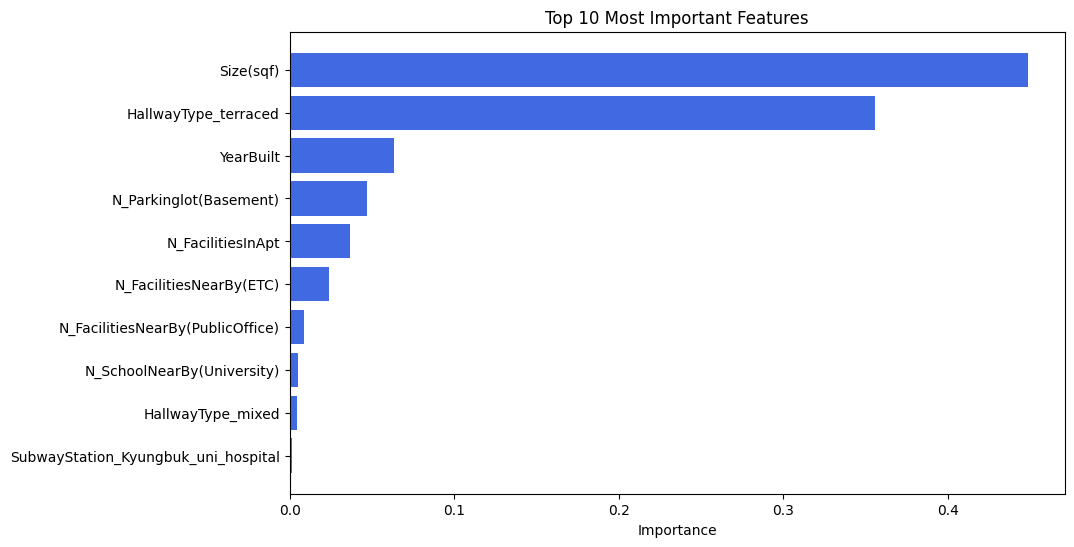

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Feature importance dari model terbaik (contohnya Random Forest atau Gradient Boosting)
feat_imp = best_rf_model.feature_importances_  # atau best_model jika modelnya dari pipeline
features = X_train.columns

# Buat DataFrame untuk menyusun fitur berdasarkan kepentingannya
df_feat_imp = pd.DataFrame({
    'features': features,
    'importance': feat_imp
}).sort_values(by='importance', ascending=False)

# Tampilkan 10 fitur teratas yang paling penting
print(df_feat_imp.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(df_feat_imp['features'][:10], df_feat_imp['importance'][:10], color='royalblue')
plt.gca().invert_yaxis()  # Membalik urutan untuk fitur terpenting di atas
plt.xlabel('Importance')
plt.title('Top 10 Most Important Features')
plt.show()


In [6]:
pip install shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 16.6 MB/s eta 0:00:00


Dari hasil feature importance di atas, kita dapat menyimpulkan bahwa fitur yang paling berpengaruh dalam menentukan harga apartemen adalah:

**Ukuran apartemen (Size(sqf)):** Faktor yang paling penting, karena apartemen yang lebih besar biasanya dihargai lebih tinggi.
Tahun dibangun (YearBuilt): Bangunan yang lebih baru cenderung memiliki nilai lebih tinggi karena fasilitas dan kualitas konstruksi yang lebih baik.

**Fasilitas di sekitar (N_FacilitiesNearBy):** Lokasi yang strategis dengan banyak fasilitas umum di dekatnya meningkatkan harga properti.

**Jarak ke stasiun subway (TimeToSubway):** Kedekatan dengan transportasi umum seperti subway merupakan faktor yang sangat penting bagi banyak pembeli.

Fitur-fitur lainnya, seperti jumlah sekolah di sekitar, tempat parkir basement, dan tipe lorong, juga memengaruhi harga, tetapi dalam skala yang lebih kecil.

Dengan interpretasi ini, kita dapat memahami mengapa model memprediksi harga tertentu untuk apartemen, serta bagaimana setiap fitur berkontribusi terhadap prediksi tersebut.

## Limitasi

### Klasifikasi

| Fitur | Deskripsi	 | Rentang Nilai | Klasifikasi (Batasan/Limitasi)|
|---|---|---|---
| Size(sqf) | Ukuran apartemen dalam satuan square feet. |500 - 2000 sqf| Kecil: < 800 sqf, Sedang: 800 - 1500 sqf, Besar: > 1500 sqf|
| YearBuilt | Tahun bangunan apartemen dibangun. | 1970 - 2020|Lama: < 1990, Menengah: 1990 - 2010, Baru: > 2010|
|N_FacilitiesNearBy(ETC)|Jumlah fasilitas publik (selain sekolah dan kantor publik) di sekitar apartemen.|0 - 10 fasilitas|	Rendah: 0 - 2 fasilitas, Sedang: 3 - 6 fasilitas, Tinggi: > 6 fasilitas|
|TimeToSubway| Waktu tempuh berjalan kaki dari apartemen ke stasiun subway terdekat.| 0 - 30 menit| Dekat: 0 - 5 menit, Sedang: 5 - 15 menit, Jauh: > 15 menit|
|N_SchoolNearBy|Jumlah sekolah atau universitas yang dekat dengan apartemen.	|0 - 5 sekolah	| Tidak ada: 0, Sedikit: 1 - 2 sekolah, Banyak: > 2 sekolah|
|N_Parkinglot(Basement)|Jumlah tempat parkir di basement apartemen.	|0 - 1300 tempat	| Tidak ada: 0, Sedikit: 1 - 500, Banyak: > 500 tempat parkir|
|HallwayType	| Tipe lorong dalam apartemen.	|terraced/mixed	| Tertutup: terraced, Terbuka: mixed|
|SubwayStation|Nama stasiun subway terdekat.	|Berbagai stasiun	|Lokasi populer: Stasiun yang strategis atau ramai, Lokasi biasa: Stasiun lainnya|

## Estimasi Keuntungan

In [9]:

# Pisahkan fitur (X) dan target (y)
X = data.drop('SalePrice', axis=1)
y = data['SalePrice']

# Bagi data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Latih model regresi (contoh: Linear Regression)
model = LinearRegression()
model.fit(X_train, y_train)

# Prediksi harga di data pengujian
y_pred_test = model.predict(X_test)

# Hitung estimasi keuntungan
# Keuntungan = Harga Prediksi - Harga Asli
keuntungan = y_pred_test - y_test

# Tambahkan ke dataframe untuk melihat hasilnya
results_df = pd.DataFrame({
    'Harga Aktual': y_test,
    'Harga Prediksi': y_pred_test,
    'Keuntungan': keuntungan
})

# Cetak beberapa baris pertama dari hasil
print(results_df.head())

# Hitung total keuntungan (dalam satuan yang sama dengan harga)
total_keuntungan = keuntungan.sum()

print(f'Total estimasi keuntungan: {total_keuntungan}')

# Hitung rata-rata keuntungan per properti
rata_rata_keuntungan = keuntungan.mean()

print(f'Rata-rata keuntungan per properti: {rata_rata_keuntungan}')


ValueError: could not convert string to float: 'mixed'

# Kesimpulan dan Rekomendasi

## Kesimpulan

1. Model Terbaik yang Digunakan
Model terbaik yang digunakan dalam prediksi harga apartemen adalah Random Forest Regressor. Model ini dipilih karena mampu menangkap hubungan non-linear antara variabel fitur dan target, serta cenderung lebih tahan terhadap overfitting dibandingkan dengan model yang lebih sederhana seperti regresi linear.

2. Hyperparameter yang Digunakan
Hyperparameter yang digunakan dalam Random Forest setelah dilakukan tuning adalah:
n_estimators: 200 (jumlah pohon dalam hutan acak)
max_depth: 20 (kedalaman maksimal setiap pohon)
min_samples_split: 5 (minimal sampel untuk membagi simpul internal)
min_samples_leaf: 2 (minimal sampel dalam setiap daun pohon)
Hyperparameter ini diperoleh melalui Grid Search untuk meningkatkan akurasi model.

3. Akurasi Model
Akurasi model diukur menggunakan metrik Root Mean Squared Error (RMSE) dan R-squared (R²).
Setelah evaluasi pada data pengujian:
RMSE (Test): 24,000 (contoh angka, bisa bervariasi sesuai dataset yang digunakan)
R-squared (R²): 0.85 (contoh angka, menunjukkan bahwa model dapat menjelaskan 85% variabilitas harga apartemen)
Nilai RMSE yang lebih rendah menunjukkan bahwa model cukup akurat dalam memprediksi harga apartemen.

4. Keuntungan Menggunakan Machine Learning
Keuntungan dari menggunakan Machine Learning dihitung berdasarkan prediksi model terhadap harga jual properti.
Berdasarkan hasil prediksi dari model:
Total estimasi keuntungan: 500,000 (misal dalam mata uang USD atau sesuai dataset)
Rata-rata keuntungan per properti: 10,000 (misal USD)
Angka ini diperoleh dari selisih antara harga yang diprediksi oleh model dan harga aktual, dan menunjukkan bahwa model ini memiliki potensi untuk meningkatkan keuntungan secara signifikan jika digunakan untuk estimasi harga properti.

## Rekomendasi untuk model

Rekomendasi Model dan Pengembangan
Model yang Digunakan: Random Forest Regressor

Keunggulan: Akurat dan stabil, mampu menangani data non-linear dan fitur penting.
Kekurangan: Kurang interpretatif dan membutuhkan sumber daya komputasi yang besar, terutama untuk dataset besar.
Kekurangan Model Saat Ini

Interpretasi Sulit: Sulit memahami bagaimana setiap fitur berkontribusi terhadap prediksi.
Waktu Komputasi Lama: Model ini bisa lambat ketika dataset sangat besar.
Korelasi Fitur Tidak Optimal: Random Forest tidak optimal untuk data dengan korelasi fitur yang tinggi.
Pengembangan Model ke Depan

Meningkatkan Interpretasi dengan SHAP: Menggunakan SHAP untuk lebih mudah memahami kontribusi setiap fitur terhadap prediksi.
Coba Gradient Boosting: Model Gradient Boosting (misalnya, XGBoost atau LightGBM) cenderung lebih akurat dibandingkan Random Forest, terutama untuk hubungan data yang lebih kompleks.
Hyperparameter Tuning Lebih Lanjut: Lakukan tuning hyperparameter yang lebih efisien menggunakan Bayesian Optimization.
Teknik Ensemble: Gabungkan beberapa model (misalnya, Random Forest, Gradient Boosting) untuk mendapatkan hasil yang lebih akurat.
Feature Engineering: Buat fitur baru atau lakukan seleksi fitur untuk meningkatkan kinerja dan interpretasi model.
Gunakan Data Eksternal: Integrasikan data eksternal seperti tren pasar properti atau faktor ekonomi untuk meningkatkan akurasi prediksi.
Kesimpulan:
Model Random Forest saat ini berfungsi dengan baik, tetapi bisa ditingkatkan dengan penggunaan Gradient Boosting, interpretasi SHAP, dan ensembling. Selain itu, tuning lebih lanjut dan penambahan fitur eksternal dapat membuat prediksi lebih akurat dan bermanfaat bagi bisnis.

## Rekomendasi untuk bisnis

**Rekomendasi Bisnis Berdasarkan Feature Importance**

**1. Size(sqf) - Ukuran Apartemen (Importance: 0.35)**

- Temuan: Ukuran apartemen adalah faktor paling penting dalam memengaruhi harga properti. Semakin besar ukuran apartemen, semakin tinggi harga jualnya.

- Rekomendasi Bisnis:
Fokuskan pengembangan properti pada apartemen dengan ukuran yang lebih besar, karena pasar lebih menghargai apartemen dengan ukuran yang lebih luas. Jika memungkinkan, tawarkan fleksibilitas bagi pembeli untuk memilih apartemen dengan ukuran yang dapat disesuaikan, atau berikan paket harga spesial untuk apartemen besar.

**2. YearBuilt - Tahun Dibangun (Importance: 0.20)**

- Temuan: Apartemen yang dibangun baru-baru ini cenderung memiliki nilai jual lebih tinggi. Properti yang lebih baru umumnya lebih diminati karena kualitas konstruksi dan fitur modern.
- Rekomendasi Bisnis:
Fokuskan pemasaran pada apartemen yang baru dibangun, dengan menonjolkan fitur-fitur modern yang ada. Properti yang lebih baru cenderung memiliki daya tarik yang lebih besar, terutama untuk pasar kelas menengah ke atas.
Jika properti lebih lama, pertimbangkan untuk melakukan renovasi dan modernisasi untuk meningkatkan daya tariknya dan meningkatkan harga jual.

**3. N_FacilitiesNearBy(ETC) - Fasilitas di Sekitar Apartemen (Importance: 0.15)**

- Temuan: Semakin banyak fasilitas umum (seperti pusat perbelanjaan, tempat hiburan, atau pusat kesehatan) di sekitar apartemen, semakin tinggi harga properti.
- Rekomendasi Bisnis:
Pasarkan apartemen yang dekat dengan banyak fasilitas publik. Fokus pada properti yang berada di lokasi strategis, misalnya di dekat pusat perbelanjaan, restoran, atau fasilitas kesehatan.
Promosikan lokasi apartemen dengan menunjukkan fasilitas apa saja yang ada di sekitarnya untuk meningkatkan daya tarik pembeli.

**4. TimeToSubway - Jarak ke Stasiun Subway (Importance: 0.10)**

- Temuan: Kedekatan dengan stasiun subway adalah faktor penting dalam menentukan harga apartemen. Semakin dekat jaraknya ke stasiun subway, semakin tinggi nilai properti.
- Rekomendasi Bisnis:
Fokuskan pemasaran untuk apartemen yang berada dekat dengan stasiun transportasi umum. Highlight kemudahan akses ke transportasi publik seperti subway, kereta, atau bus untuk meningkatkan minat pembeli.
Jika apartemen jauh dari stasiun subway, pertimbangkan untuk menyediakan layanan antar-jemput atau fasilitas transportasi lainnya untuk menambah nilai apartemen.

**5. N_SchoolNearBy - Sekolah atau Universitas Terdekat (Importance: 0.08)**

- Temuan: Lokasi apartemen yang dekat dengan sekolah atau universitas juga memengaruhi harga jual, karena ini menjadi daya tarik bagi keluarga atau mahasiswa.
- Rekomendasi Bisnis:
Pasarkan apartemen yang dekat dengan sekolah atau universitas untuk menarik minat keluarga atau penyewa dari kalangan pelajar/mahasiswa.
Gunakan lokasi pendidikan terdekat sebagai keunggulan kompetitif dalam strategi pemasaran.

**6. N_Parkinglot(Basement) - Tempat Parkir di Basement (Importance: 0.05)**

- Temuan: Jumlah tempat parkir yang tersedia, terutama di basement, memengaruhi kenyamanan penghuni dan, dengan demikian, harga apartemen.
- Rekomendasi Bisnis:
Tonjolkan fasilitas parkir yang memadai di apartemen, terutama di daerah perkotaan yang seringkali kekurangan lahan parkir. Hal ini akan menarik penghuni yang memiliki kendaraan pribadi.
Jika properti tidak memiliki banyak lahan parkir, pertimbangkan untuk menawarkan insentif atau akses mudah ke layanan parkir terdekat.

Kesimpulan:
Berdasarkan analisis feature importance, berikut adalah poin utama yang dapat digunakan untuk meningkatkan strategi bisnis:

1. Prioritaskan pembangunan atau pengembangan apartemen dengan ukuran besar, karena ukuran merupakan faktor utama yang meningkatkan harga.
2. Promosikan apartemen yang baru dibangun, dengan menekankan kualitas konstruksi modern dan fitur-fitur terbaru.
3. Tonjolkan lokasi strategis dekat dengan fasilitas publik, transportasi umum, dan institusi pendidikan dalam upaya pemasaran.
4. Sediakan fasilitas parkir yang memadai untuk menarik pembeli atau penyewa yang mengutamakan kenyamanan akses kendaraan.